In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## TODO:
1. Specialize smooth nonlinear least squares solver

2. Better stopping conditions

3. Anneal out loss

4. Experiment with initialization at solution. 

In [6]:
dt = 0.1
noise_var = 0.
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2500,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100
)
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=50.,
        fixed_data_weight=50.,
        max_inner_iterations=500,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.11684997, dtype=float64), 'data_weight': 50.0, 'colloc_weight': 50.0}
Warm Start


  0%|          | 0/2500 [00:00<?, ?it/s]

Iteration 0, loss = 2.826e+04, gradnorm = 6.418e+06, alpha = 4.167, improvement_ratio = 0.9829
Iteration 1, loss = 1.364e+03, gradnorm = 3.615e+06, alpha = 3.472, improvement_ratio = 0.9614
Iteration 2, loss = 268.6, gradnorm = 1.272e+06, alpha = 2.894, improvement_ratio = 0.9482
Iteration 3, loss = 219.6, gradnorm = 3.007e+05, alpha = 2.894, improvement_ratio = 0.3664
Iteration 4, loss = 160.1, gradnorm = 1.682e+05, alpha = 2.894, improvement_ratio = 0.4126
Iteration 5, loss = 81.52, gradnorm = 1.893e+05, alpha = 2.894, improvement_ratio = 0.6365
Iteration 68, loss = 0.7686, gradnorm = 8.11e-05, alpha = 0.2223, improvement_ratio = 154.0
Model after smooth warm start
(x)' = 0.003 1 + -9.998 x + 9.999 y + -0.001 z
(y)' = -0.001 1 + 27.997 x + -0.998 y + -1.000 x z
(z)' = -0.003 1 + -2.666 z + 1.000 x y
Alternating Activeset Sparsifier
Line search Failed
9 active coeffs changed
Line search Failed
Active set stabilized
Line search Failed


In [7]:
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


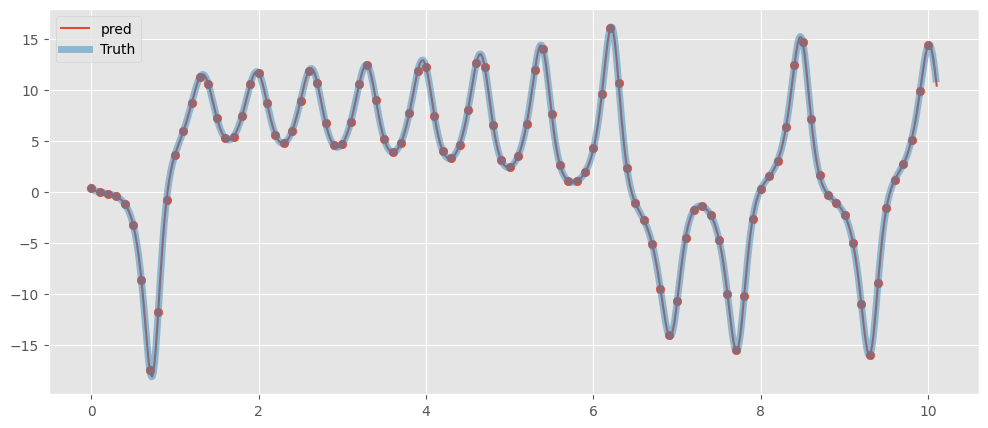

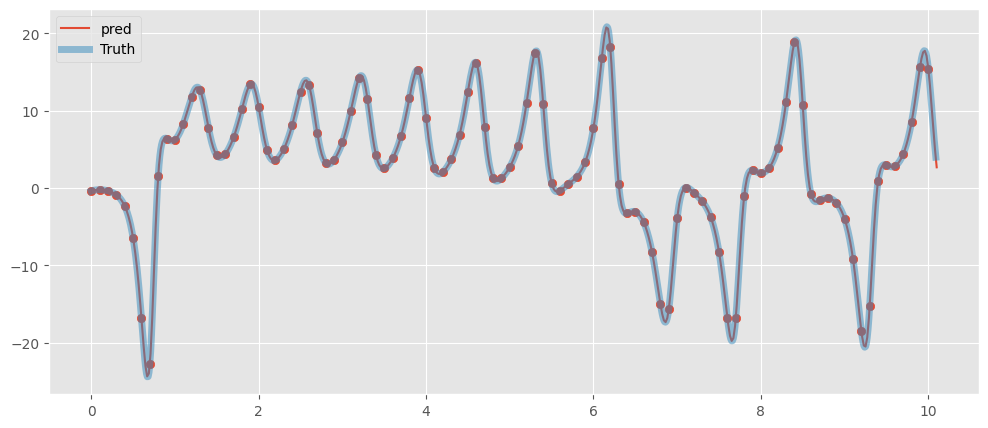

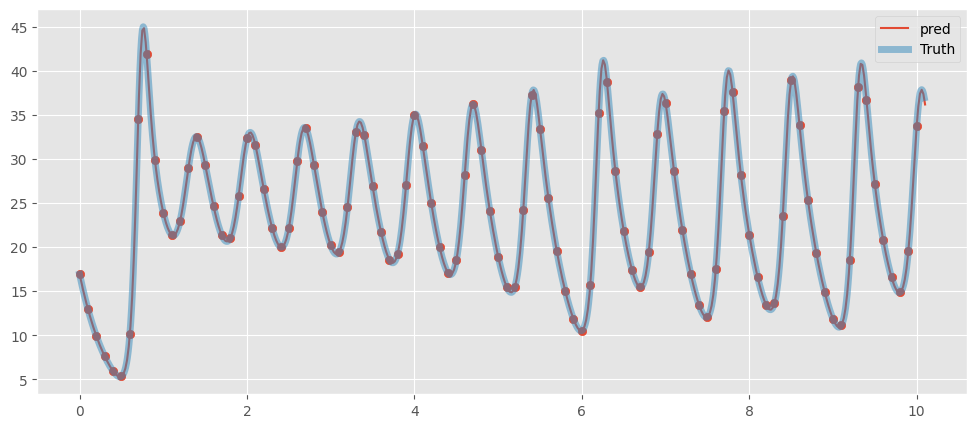

In [8]:
t_grid = jnp.linspace(0,10.1,500)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.figure(figsize=(12,5))
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.plot(t_grid,x_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,i],lw = 5,alpha = 0.5,label = 'Truth')
    plt.legend()
    plt.show()

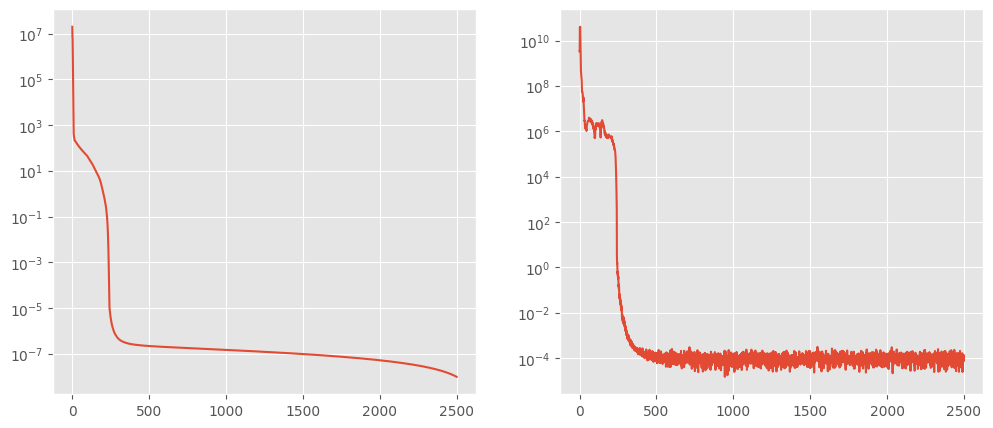

In [12]:
opt = model.opt_result[0]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(opt.loss_vals - opt.loss_vals[-1]+1e-8)
plt.yscale('log')
plt.subplot(1,2,2)
plt.plot(opt.gradnorm)
plt.yscale('log')
plt.show()

In [21]:
opt = model.opt_result[1]
opt.history['objval'][-1]

[Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, d